# Visualizing Groups & Clusters

As we saw in our previous notebooks we can easily scatter cluster data and assign different colors to each cluster to differentiate them. There are additional things we can do to visualize our data space as well as the clusters themselves.

## Individual Cluster

Once we have clusters determined and assigned, there is nothing that prevents us from examining individual clusters. From here we can perform any analysis we want. We can begin just as we did in the last notebook and use `sklearn` to produce some blobs and compute the k-means. Then we are going to highlight the centroids.

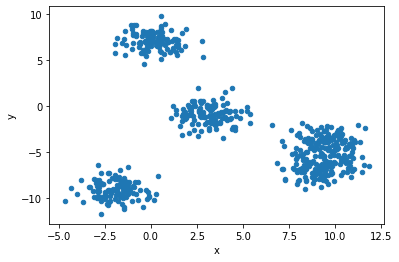

In [1]:
import pandas as pd
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=600, centers=5, random_state=13337)
_data = X.reshape((600,2)).T
data = pd.DataFrame({
    'x': _data[0],
    'y': _data[1]
})
ax = data.plot.scatter(x='x', y='y')

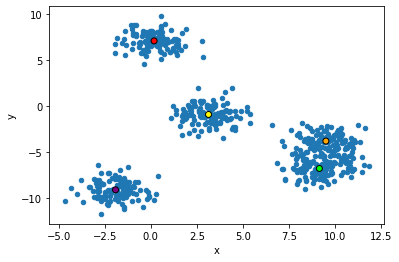

In [2]:
import matplotlib as mpl
cmap = mpl.colors.ListedColormap(
    ['purple', 'red', 'orange', 'yellow', 'lime']
)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=2)
centroids = kmeans.fit(X).cluster_centers_.T
ax.scatter(centroids[0], centroids[1], c=['purple', 'red', 'orange', 'yellow', 'lime'], edgecolor='black')
ax.figure

With our cluster identified we can actually just pull out the cluster assignments from `sklearn` and assign them to a column within our data frame. Because the order of the assignments matches the order of our data we have no problem at all just inserting the column as it is. The utility function `fit_predict` returns the assignments.

Once we add the new cluster column, we can then filter (or if we wanted to, group) our data. Below we can extract the first cluster and scatter its points.

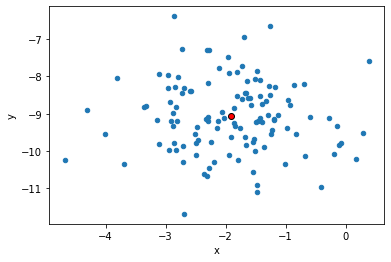

In [3]:
data['cluster'] = kmeans.fit_predict(X)
cluster_0 = data[data.cluster==0]
ax = cluster_0.plot.scatter(x='x', y='y')

centroid = centroids[:,0]
ax.scatter(centroid[0], centroid[1], color='red', edgecolor='black')

We could further analyze this cluster, or extract the others, to learn mroe about our data.

## Voronoi Diagrams

Something else that we can do is generate Voronoi Diagrams. This involves partitioning our space (canvas) such that we define hard boundaries between clusters. This allows us to better understand and visualize the spaces occupied by clusters and how clusters are separated (in cases where clusters are directly adjacent).

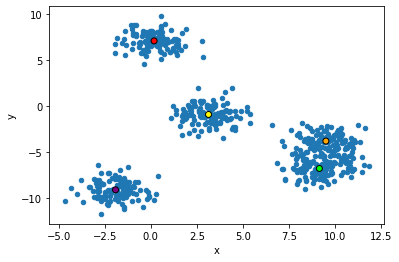

In [4]:
ax = data.plot.scatter(x='x', y='y')
centroids = kmeans.fit(X).cluster_centers_.T
ax.scatter(centroids[0], centroids[1], c=['purple', 'red', 'orange', 'yellow', 'lime'], edgecolor='black')
xlim = ax.get_xlim()
ylim = ax.get_ylim()

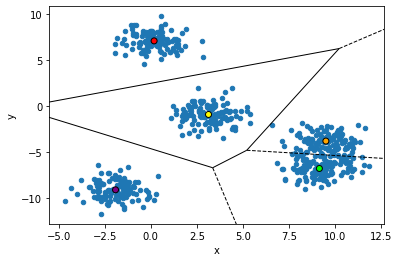

In [5]:
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(centroids.T)
voronoi_plot_2d(vor, show_points=False,  show_vertices=False, ax=ax)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.figure

This function below, taken from [here](https://gist.github.com/pv/8036995), is a utility function that allows us to fill in our Voronoi diagram polygons.

In [6]:
import numpy as np

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge
            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius * 10

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

We use our utility function to define our regions as sets of vertices, which allow us to use `matplotlib's` `fill` function to draw our partitions. Note the use of `zorder` to ensure that the partitions fall behind our data. We choose `-10` sort of arbitrarily - we know that -10 will be less than our data's default z-order which is all that matters (lower z-order value means the elements are stacked "back" on the canvas).

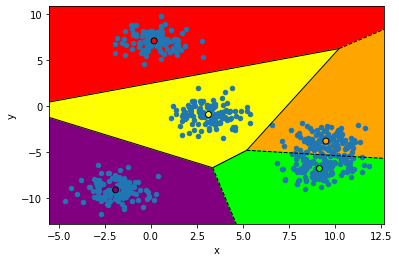

In [7]:
regions, vertices = voronoi_finite_polygons_2d(vor)
for (region, color) in zip(regions, ['purple', 'red', 'orange', 'yellow', 'lime']):
    polygon = vertices[region]
    ax.fill(*zip(*polygon), c=color, zorder=-10)
ax.figure

This is a way for us to visualize potential boundaries in the data and what sort of space "belongs" to each cluster.

## Multivariate Data

Consider groups of multivariate data. The entire dataset prescribes to the same structure, but the groups making up the set are distinct. It may be helpful to produce high level views of the data comparing the groups and their dependent variables. We have a few tools at our disposal here.

We can consider the iris data set provided by `pandas`:

In [8]:
iris_df = pd.read_csv(
    'https://raw.github.com/pandas-dev/'
    'pandas/master/pandas/tests/io/data/csv/iris.csv'
)
iris_df

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


Here we have measurements of sepals and petals for 150 flowers, 50 for each of the flowers Iris setosa, Iris versicolor, and Iris virginica of the Iris genus. The data is already grouped easily by the `Name` column, and we can begin visualizing some of these metrics:

<AxesSubplot:ylabel='SepalLength'>

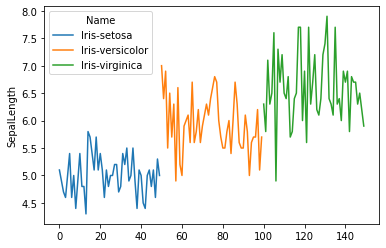

In [9]:
import seaborn as sns
sns.lineplot(x=iris_df.index, y='SepalLength', hue='Name', data=iris_df)

This alone tells us little - we can see the upward trend in sepal length through the various species, but otherwise this does not tell us much. We can certainly try to visualize something similar for the other 3 metrics that we have.

<AxesSubplot:ylabel='PetalWidth'>

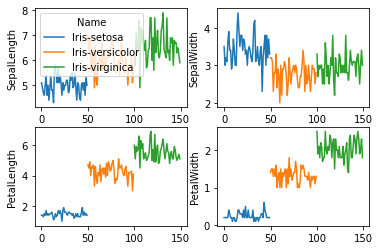

In [10]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2)
sns.lineplot(x=iris_df.index, y='SepalLength', hue='Name', data=iris_df, ax=axes[0][0])
sns.lineplot(x=iris_df.index, y='SepalWidth', hue='Name', data=iris_df, ax=axes[0][1], legend=False)
sns.lineplot(x=iris_df.index, y='PetalLength', hue='Name', data=iris_df, ax=axes[1][0], legend=False)
sns.lineplot(x=iris_df.index, y='PetalWidth', hue='Name', data=iris_df, ax=axes[1][1], legend=False)

We can see clear separations from group to group, but surely there is a better way to try to grasp at the measurements in a singular view. Stacking all of these plots as they are is not the solution either. `seaborn` gives access to a few more tools. In particular we can use a `pairplot` to visualize distributions across our spectrum of data, pairing each metric against each metric:

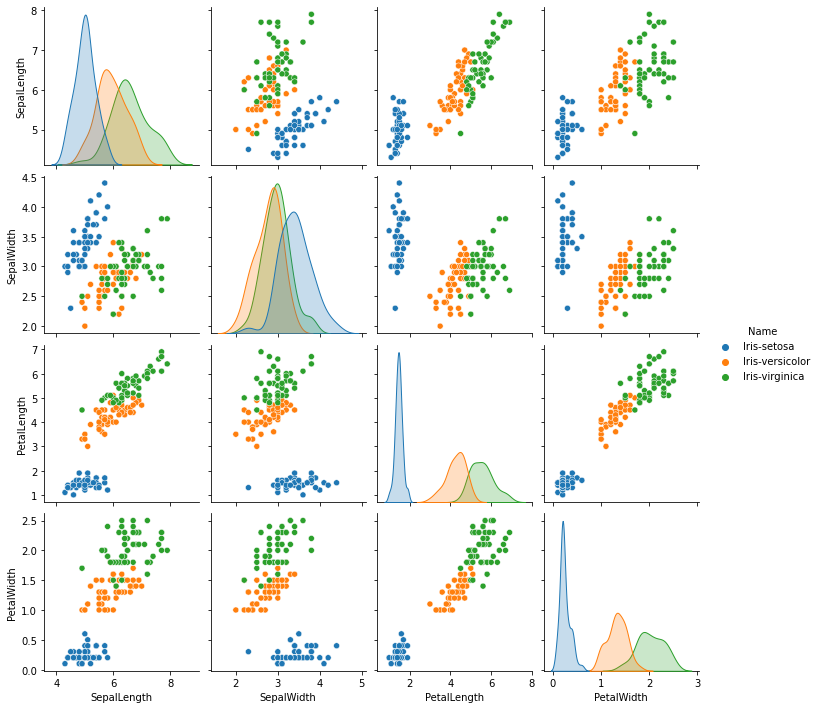

In [11]:
import seaborn as sns
sns.pairplot(iris_df, hue='Name')

`seaborn` amazingly enough allows us to change the kind of plots we disperse throughout the grid. We can instruct it to use kernel density estimates (KDE) to show smoothed probability density functions.

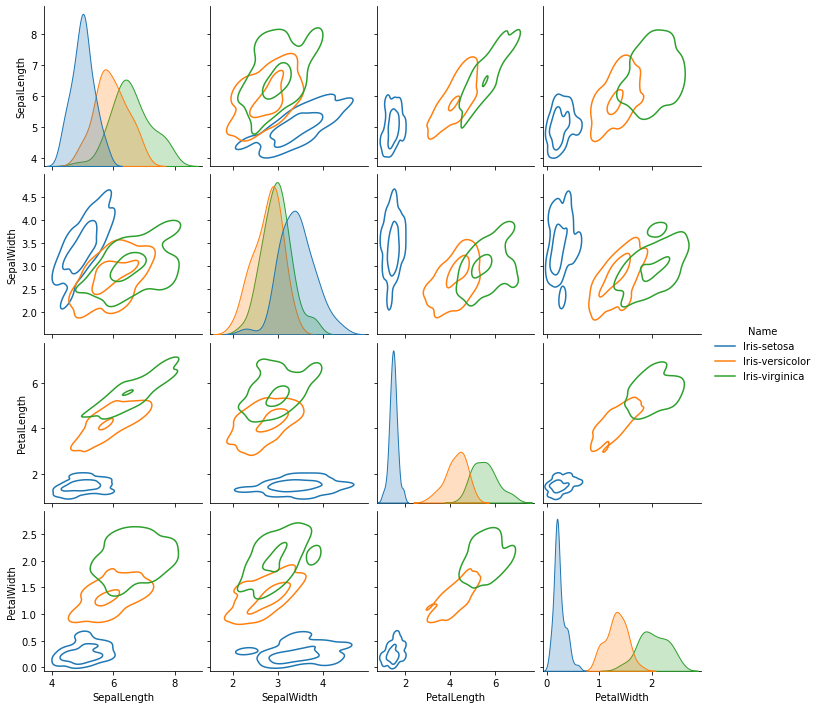

In [12]:
sns.pairplot(iris_df, hue='Name', plot_kws={'levels': 3}, kind='kde')

We can also decide to compute 2-dimensional histograms, with darker hues indicating higher densities. In this way it acts very much like a heatmap.

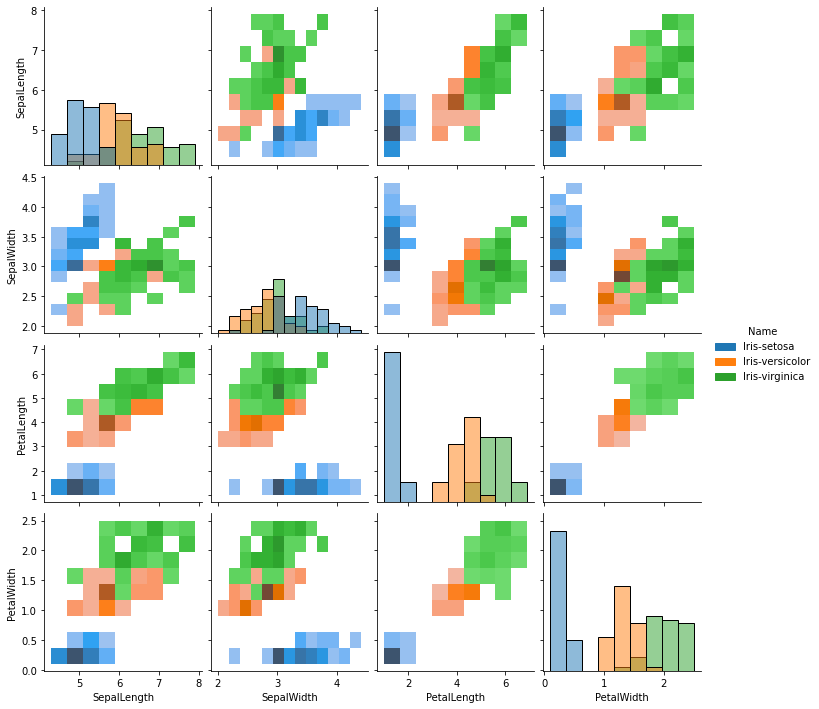

In [13]:
sns.pairplot(iris_df, hue='Name', kind='hist')

It would be great if we could get all of our data into a single ciew. We can look at `parallel coordinates`, which is just a layout of every observation in our dataset broken down by the individual variables that make them up, colored by group. Lines are drawn between the variables that correspond to the same observation. This gives us a complete view of the entire data space and allows us to see trends across groups much easier.

<AxesSubplot:>

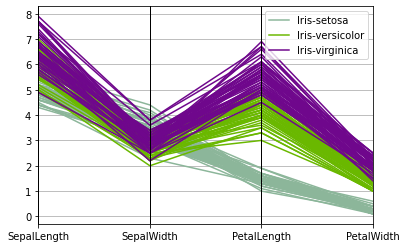

In [14]:
pd.plotting.parallel_coordinates(iris_df, 'Name')

This is great! We can see all of our data in a single view. We can see that the versicolor and virginica share similar proportions and are more similiar to eachother than they are to the setosa. We can compare the structure of patterns of the data by using `Andrews Curves` which is a set of finite Fourier series.

<AxesSubplot:>

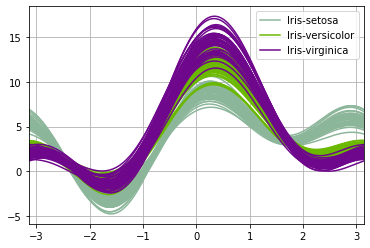

In [15]:
pd.plotting.andrews_curves(iris_df, 'Name')

This view allows us to see patterns within the structure of the data to identify where data is similiar or otherwise disimilar. We can spot outliers within the data if any are present.